In [263]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

from centrex_tlf import states, couplings, transitions, hamiltonian, lindblad

In [163]:
Ez = smp.symbols("E_z")

In [164]:
X_states_uncoupled = states.generate_uncoupled_states_ground(Js=[0, 1, 2, 3])

In [165]:
ham_uncoupled = hamiltonian.generate_uncoupled_hamiltonian_X(X_states_uncoupled)
ham_func = hamiltonian.generate_uncoupled_hamiltonian_X_function(ham_uncoupled)

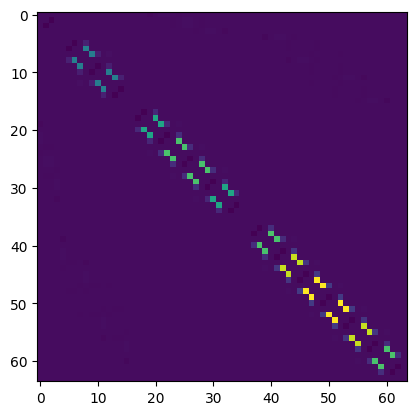

In [166]:
ham = ham_func([0, 0, 0], [0, 0, 1e-5]).real
np.fill_diagonal(ham, 0)
fig, ax = plt.subplots()

ax.imshow(ham)

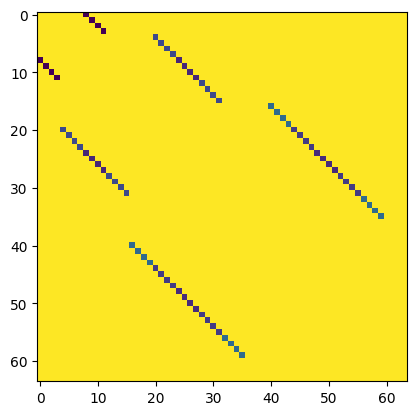

In [167]:
fig, ax = plt.subplots()

ax.imshow(ham_uncoupled.HSz.real)

In [168]:
H0 = ham_func([0, 0, 0], [0, 0, 1e-5])
eigenvals, eigenvecs = np.linalg.eigh(H0)
HSz = eigenvecs.conj().T @ (ham_uncoupled.HSz) @ eigenvecs

# filter small values
m = np.abs(HSz) < (np.abs(HSz).max() / 1e4)
HSz[m] = 0

# make states and filter
QN = hamiltonian.matrix_to_states(eigenvecs, list(X_states_uncoupled))
QN = [qn.remove_small_components().normalize() for qn in QN]

In [169]:
QN_coupled = [qn.transform_to_coupled() for qn in QN]
QN_coupled = [qn.remove_small_components().normalize() for qn in QN_coupled]

In [265]:
from typing import List


from centrex_tlf.couplings.transition import TransitionSelector


trans = [
    transitions.MicrowaveTransition(0, 1),
    transitions.MicrowaveTransition(1, 2),
]

transition_selectors: List[TransitionSelector] = (
    couplings.generate_transition_selectors(
        transitions=trans,
        polarizations=[
            [couplings.polarization_Z, couplings.polarization_X],
            [couplings.polarization_Z, couplings.polarization_X],
        ],
    )
)

QN_coupled_largest = [qn.largest for qn in QN_coupled]
coupling_fields = []
for trans in transition_selectors:
    ground_states = [
        QN_coupled[idx]
        for idx in np.unique(
            [QN_coupled_largest.index(qn.largest) for qn in trans.ground]
        )
    ]
    excited_states = [
        QN_coupled[idx]
        for idx in np.unique(
            [QN_coupled_largest.index(qn.largest) for qn in trans.excited]
        )
    ]

    cf = []
    for pol in trans.polarizations:
        cmat = couplings.generate_coupling_matrix(
            QN_coupled, ground_states, excited_states, pol
        )
        # filter small values
        cmat[np.abs(cmat) < (np.abs(cmat).max() / 1e4)] = 0
        cf.append(couplings.CouplingField(pol, cmat))

    main_coupling = np.abs(cf[0].field).max()
    idg, ide = np.where(np.abs(cf[0].field) == main_coupling)[0]
    coupling_fields.append(
        couplings.CouplingFields(
            QN_coupled[idg],
            QN_coupled[ide],
            main_coupling,
            ground_states,
            excited_states,
            cf,
        )
    )

In [ ]:
H_symbolic = lindblad.generate_total_symbolic_hamiltonian(
    QN_coupled, H0, coupling_fields, transition_selectors
)